In [3]:
from __future__ import division

from microfaune_package.microfaune.detection import RNNDetector
from microfaune_package.microfaune import audio
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import numpy as np
import pdb
import csv
import argparse
from scipy.io import wavfile
import scipy.signal as scipy_signal
import pandas as pd

## Function that attempts to isolate bird calls from clips 

In [2]:
## TODO Modify this function so that a user can play around with different bells and whistles.
def isolate(scores, samples, sample_rate, audio_dir, filename):
    # calculate original duration
    old_duration = len(samples) / sample_rate

    # create entry for audio clip
    entry = {'folder'  : audio_dir,
             'file'    : filename,
             'channel' : 0,
             'duration': old_duration,
             'stamps'  : [],
             'labels'  : []}

    # Variable to modulate when encapsulating this function.
    # treshold is 'thresh_mult' times above median score value
    thresh_mult = 2
    thresh = np.median(scores) * thresh_mult

    
    # how many samples one score represents
    # Scores meaning local scores
    samples_per_score = len(samples) // len(scores)
    
    # isolate samples that produce a score above thresh
    isolated_samples = np.empty(0, dtype=np.int16)
    prev_cap = 0        # sample idx of previously captured
    for i in range(len(scores)):
        # if a score hits or surpasses thresh, capture 1s on both sides of it
        if scores[i] >= thresh:
            # score_pos is the sample index that the score corresponds to
            score_pos = i * samples_per_score
 
            # upper and lower bound of captured call
            # sample rate is # of samples in 1 second: +-1 second
            lo_idx = max(0, score_pos - sample_rate)
            hi_idx = min(len(samples), score_pos + sample_rate)
            lo_time = lo_idx / sample_rate
            hi_time = hi_idx / sample_rate
            
            # calculate start and end stamps
            # create new sample if not overlapping or if first stamp
            if prev_cap < lo_idx or prev_cap == 0:
                new_stamp = [lo_time, hi_time]
                entry['stamps'].append(new_stamp)
                entry['labels'].append(1)
            # extend same stamp if still overlapping
            else:
                entry['stamps'][-1][1] = hi_time

            # mark previously captured to prevent overlap collection
            lo_idx = max(prev_cap, lo_idx)
            prev_cap = hi_idx

            # add to isolated samples
            # sub-clip numpy array
            isolated_samples = np.append(isolated_samples,samples[lo_idx:hi_idx])

    # calculate new duration
    new_duration = len(isolated_samples) / sample_rate
    percent_reduced = 1 - (new_duration / old_duration)
    print('Reduced {} from {:.2f}s to {:.2f}s. {:.2%} reduced.'.format( \
            filename, old_duration, new_duration, percent_reduced))
        
    # write file
    # new_filename = filename[:-4] + "_RED" + filename[-4:]
    # wavfile.write(audio_dir + new_filename, sample_rate, isolated_samples)
    
    return entry

##  Function that creates the CSV of expected bird calls in a clip

In [3]:

def calc_local_scores(bird_dir):
    # init detector
    detector = RNNDetector()
    # init labels dict
    annotations = []

    # generate local scores for every bird file in chosen directory
    for audio_file in os.listdir(bird_dir):
        # skip directories
        if os.path.isdir(bird_dir+audio_file): continue
        
        # read file
        raw_sample_rate, raw_samples = wavfile.read(bird_dir + audio_file)
        
        # downsample the sample if > 22.05 kHz
        if raw_sample_rate > 44100:
            rate_ratio = 44100 / raw_sample_rate
            samples = scipy_signal.resample(
                    raw_samples, int(len(raw_samples)*rate_ratio))
            sample_rate = 44100
            # resample produces unreadable float32 array so convert back
            samples = np.asarray(samples, dtype=np.int16)
            
            # add DS to end of downsampled file
            new_filename = audio_file[:-4] + "_DS" + audio_file[-4:]
            audio_file = new_filename
            
            # write downsampled file
            wavfile.write(bird_dir + new_filename, sample_rate, samples)
        else:
            sample_rate = raw_sample_rate
            samples = raw_samples
        
        # convert mono to stereo if needed
        if len(samples.shape) == 2:
            samples = samples.sum(axis=1) / 2

        # detection
        try:
            # for wavs
            if audio_file.lower().endswith('.wav'):
                _, local_score = detector.predict_on_wav(bird_dir + audio_file)
                print("Loaded", audio_file)
            # for mp3s
            elif audio_file.lower().endswith('.mp3'):
                _, local_score = detector.predict(bird_dir + audio_file)
                print("Loaded", audio_file)
            else:
                print("Invalid file extension, skipping", audio_file)
                continue
        except:
            print("Error in file, skipping", audio_file)
            continue
        
        # get duration of clip
        duration = len(samples) / sample_rate
        
        # write local score file in chosen directory
        # not needed for csv output to opensoundscape
        # needed for matplotlib graph of local scores
        with open("./" + audio_file[:-4]+"_LS.txt", "w") as f:
            f.write(str(duration) + "\n")
            f.write(str(len(local_score))+"\n")
            for sc in local_score:
                f.write(str(sc) + '\n')
        
        # isolate bird sounds in the clip by eliminating dead noise
        new_entry = isolate(local_score, samples, sample_rate, bird_dir, audio_file)
        annotations.append(new_entry)

    # generate local scores for every nonbird file in chosen directory
#    for audio_file in os.listdir(nonbird_dir):
        # skip directories
#        if os.path.isdir(nonbird_dir+audio_file): continue
    
        # read file
#        raw_sample_rate, raw_samples = wavfile.read(nonbird_dir + audio_file)
        
        # downsample the sample if > 44.1 kHz
#        if raw_sample_rate > 22050:
#            rate_ratio = 22050 / raw_sample_rate
#            samples = scipy_signal.resample(
#                    raw_samples, int(len(raw_samples)*rate_ratio))
#            sample_rate = 22050
            # resample produces unreadable float32 array so convert back
#            samples = np.asarray(samples, dtype=np.int16)
            
            # add DS to end of downsampled file
#            new_filename = audio_file[:-4] + "_DS" + audio_file[-4:]
#            audio_file = new_filename
            
            # write downsampled file
#            wavfile.write(nonbird_dir + new_filename, sample_rate, samples)
#        else:
#            sample_rate = raw_sample_rate
#            samples = raw_samples
        
        # convert mono to stereo if needed
#        if len(samples.shape) == 2:
#            samples = samples.sum(axis=1) / 2

        # get duration of clip
#        duration = len(samples) / sample_rate

        # create entry for audio clip
#        new_entry = {'folder'  : nonbird_dir,
#                     'file'    : audio_file,
#                     'channel' : 0,
#                     'duration': duration,
#                     'stamps'  : [[0,duration]],
#                     'labels'  : [0]}
#        annotations.append(new_entry)

    # write csv with time stamps and labels
    header = ["FOLDER","IN FILE","CHANNEL","OFFSET","DURATION","MANUAL ID"]
    with open("annotations.csv", "w") as f:
        writer = csv.writer(f)
        # write titles of columns
        writer.writerow(header)
        
        for el in annotations:
            for i in range(len(el['stamps'])):
                clip_duration = el['stamps'][i][1] - el['stamps'][i][0]
                writer.writerow([el['folder'],
                                 el['file'], 
                                 el['channel'],
                                 el['stamps'][i][0], # start time or offset 
                                 clip_duration, # end - start
                                 el['labels'][i]])


In [4]:
# Testing out the two functions above on a test set of some clips
calc_local_scores("/home/jacob/Acoustic-Species-Identification/passive-acoustic-biodiversity/BinaryBirdDet/TEST/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded 20190622_210000_DS.WAV
Reduced 20190622_210000_DS.WAV from 60.00s to 55.34s. 7.76% reduced.
Loaded HowlerMonkey1_DS.WAV
Reduced HowlerMonkey1_DS.WAV from 60.00s to 44.67s. 25.56% reduced.
Loaded 20190622_210000_DS.WAV
Reduced 20190622_210000_DS.WAV from 60.00s to 55.34s. 7.76% reduced.
Loaded 20190624_152000_DS.WAV
Reduced 20190624_152000_DS.WAV from 60.00s to 2.65s. 95.58% reduced.
Loaded 20190623_222000_DS.WAV
Reduced 20190623_222000_DS.WAV from 60.00s to 13.33s. 77.78% reduced.
Loaded BlackFacedAntbird1.wav
Reduced BlackFacedAntbird1.wav from 31.22s

## Function that uses the local scores and compares to the spectrogram

In [97]:
def local_line_graph(local_scores, clip_name, scores_dir):
    # load signal to get spectrogram
    #home = str(Path.home())
    #wav_path = os.path.join(
    #        home, "../../media/e4e/New Volume/AudiomothData/AM15_16_Birds/")
    # remove file extension and _LS label from end of file
#    wav_name = wav_path + clip_name[:-7] + ".WAV"
    # load file
    sample_rate, samples = wavfile.read(clip_name)

    # calculate time stamps - x axis
    # takes first two lines
    duration = local_scores.pop(0)
    num_scores = local_scores.pop(0)

    step = duration / num_scores
    time_stamps = np.arange(0, duration, step)
    print(len(time_stamps))
    print(len(local_scores))

    if len(time_stamps) > len(local_scores):
        time_stamps = time_stamps[:-1]

    # general graph features
    fig, axs = plt.subplots(2)
    fig.set_figwidth(22)
    fig.set_figheight(10)
    fig.suptitle("Spectrogram and Local Scores for "+clip_name)
    # score line plot - top plot
    axs[0].plot(time_stamps, local_scores)
    axs[0].set_xlim(0,duration)
    axs[0].set_ylim(0,1)
    axs[0].grid(which='major', linestyle='-')
    # spectrogram - bottom plot
    # Will require the input of a pandas dataframe
    Pxx, freqs, bins, im = axs[1].specgram(samples, Fs=sample_rate,
            NFFT=4096, noverlap=2048,
            window=np.hanning(4096), cmap="ocean")
    axs[1].set_xlim(0,duration)
    axs[1].set_ylim(0,22050)
    axs[1].grid(which='major', linestyle='-')

    # save graph
#    plt.savefig("test.png")


1345
1345


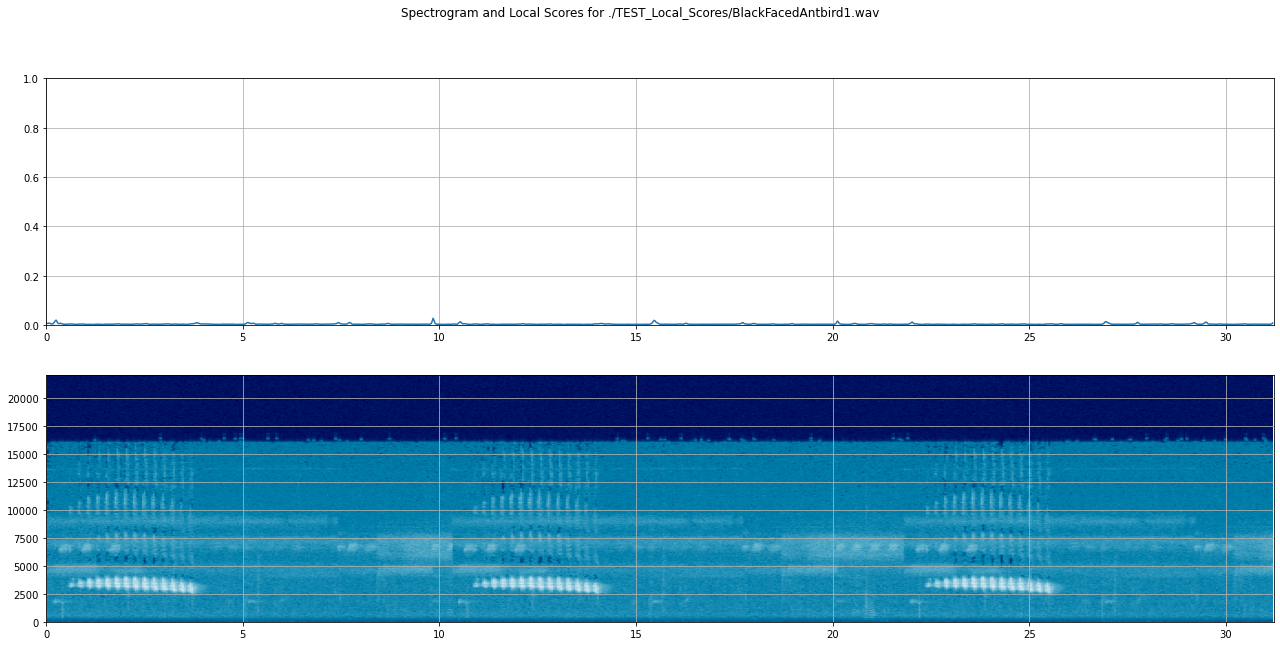

In [98]:
# Quick Test on a xeno-canto clip
local_scores = []
with open("./TEST_Local_Scores/BlackFacedAntbird1_LS.txt","r") as f:
    for line in f:
        local_scores.append(float(line.strip()))
local_line_graph(local_scores, "./TEST_Local_Scores/BlackFacedAntbird1.wav", "./TEST_Local_Scores/")

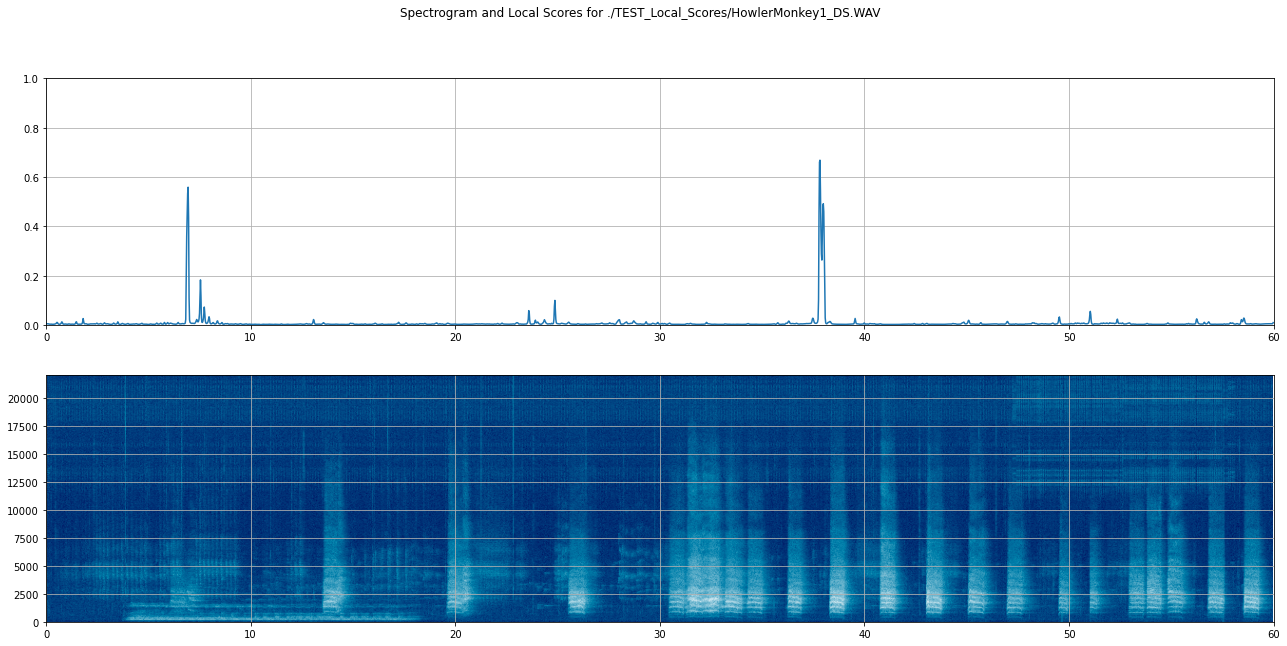

In [7]:
# Quick Test on an Audiomoth File
local_scores_AM = []
with open("./TEST_Local_Scores/HowlerMonkey1_DS_LS.txt","r") as f:
    for line in f:
        local_scores_AM.append(float(line.strip()))
local_line_graph(local_scores_AM, "./TEST_Local_Scores/HowlerMonkey1_DS.WAV", "./TEST_Local_Scores/")

## Testing out highlighting regions on a spectrogram

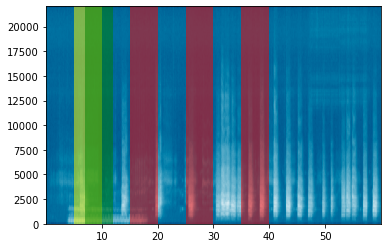

In [52]:
file_path = "./TEST_Local_Scores/HowlerMonkey1_DS.WAV"
SAMPLE_RATE, SIGNAL = wavfile.read(file_path)
plt.specgram(SIGNAL,Fs=SAMPLE_RATE,cmap="ocean");
plt.axvspan(xmin=5,xmax=10,facecolor='yellow',alpha=0.5)
minval = 15
maxval = 20
for ndx in range(3):
    plt.axvspan(xmin=minval,xmax=maxval,facecolor='red',alpha=0.5)
    minval += 10
    maxval += 10
plt.axvspan(xmin=7,xmax=12,facecolor="green",alpha=0.5)

## Highlighting based on the automated csv labels

HowlerMonkey1_DS.WAV


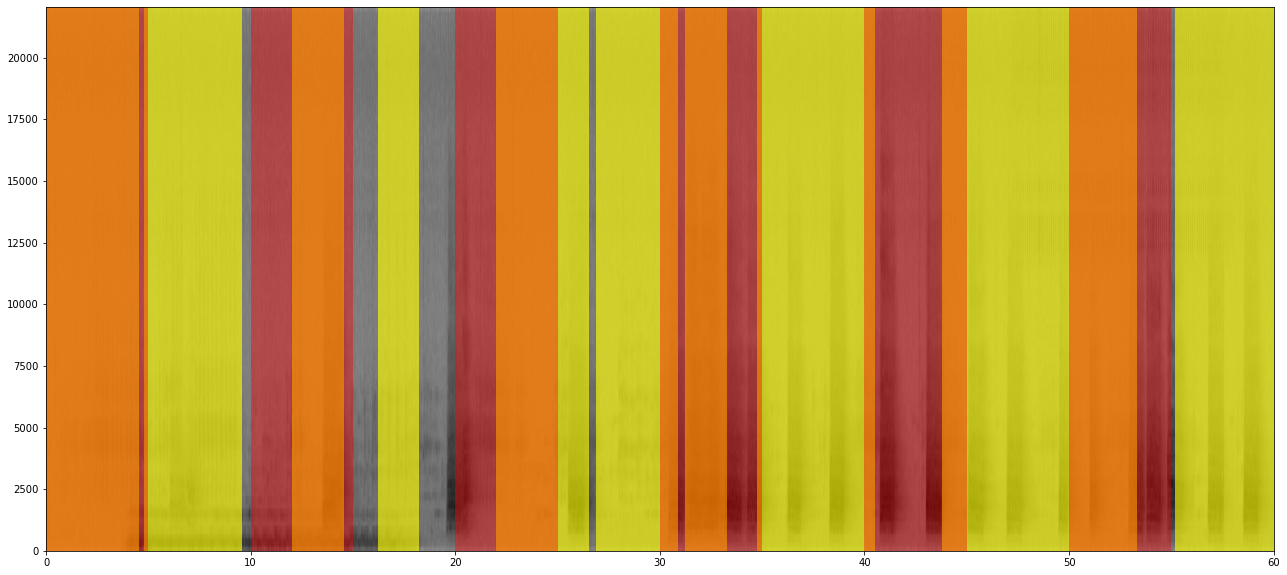

In [53]:
# Taking in the automated microfaune labels
test_automated_labels = pd.read_csv("annotations.csv");
fake_human_labels = pd.read_csv("test_ground_truth.csv");
# Reducing it down to just the clip that we want.
file_name = file_path.split("/")
file_name = file_name[-1]
print(file_name)
specific_clip_dataframe_bot = test_automated_labels[test_automated_labels['IN FILE'].str.contains(file_name)]
specific_clip_dataframe_human = fake_human_labels[fake_human_labels['IN FILE'].str.contains(file_name)]
#print(specific_clip_dataframe)
# Creating a new spectrogram
plt.figure(figsize=(22,10))
plt.specgram(SIGNAL,Fs = SAMPLE_RATE, cmap="Greys")
# Looping through each row in the reduced dataframe
for row in specific_clip_dataframe_bot.index:
    minval = specific_clip_dataframe_bot["OFFSET"][row]
    maxval = specific_clip_dataframe_bot["OFFSET"][row] + specific_clip_dataframe_bot["DURATION"][row]
    plt.axvspan(xmin=minval,xmax=maxval,facecolor="yellow",alpha=0.4)
for row in specific_clip_dataframe_human.index:
    minval = specific_clip_dataframe_human["OFFSET"][row]
    maxval = specific_clip_dataframe_human["OFFSET"][row] + specific_clip_dataframe_human["DURATION"][row]
    plt.axvspan(xmin=minval,xmax=maxval,facecolor="red",alpha=0.4)
plt.xlim(0,60);
plt.savefig("Annotations_Highlights.png")

Bird Label Overlap Percentage: 0.618


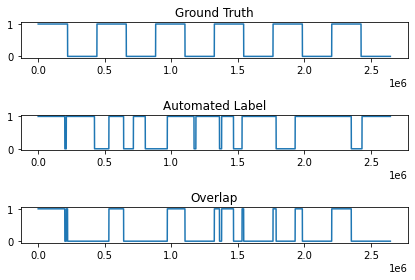

In [13]:
## Create a function to compare the annotations of microfaune to human labels overlap/ground_truth

# Initializing some numpy arrays
human_arr = np.zeros(SIGNAL.shape)
bot_arr = np.zeros(SIGNAL.shape)

# 
for row in specific_clip_dataframe_bot.index:
    minval = int(round(specific_clip_dataframe_bot["OFFSET"][row]*SAMPLE_RATE,0))
    maxval = int(round((specific_clip_dataframe_bot["OFFSET"][row] + specific_clip_dataframe_bot["DURATION"][row]) *SAMPLE_RATE,0))
    bot_arr[minval:maxval] = 1
for row in specific_clip_dataframe_human.index:
    minval = int(round(specific_clip_dataframe_human["OFFSET"][row]*SAMPLE_RATE,0))
    maxval = int(round((specific_clip_dataframe_human["OFFSET"][row] + specific_clip_dataframe_human["DURATION"][row])*SAMPLE_RATE,0))
    human_arr[minval:maxval] = 1
plt.subplot(3,1,1)
plt.plot(human_arr)
plt.title("Ground Truth")
plt.subplot(3,1,2)
plt.plot(bot_arr)
plt.title("Automated Label")
# Finding where there exists overlap between the human label and automated bird labels.
bird_label_overlap = human_arr*bot_arr
plt.subplot(3,1,3)
plt.plot(bird_label_overlap)
plt.title("Overlap")
plt.tight_layout()


# Comparing the overlap of bird labels to ground truth.
overlap_bird = len(np.where(bird_label_overlap==1)[0])
#print(overlap_bird)
human_label_size = len(np.where(human_arr==1)[0])
#print(human_label_size)
print("Bird Label Overlap Percentage: " + str(round(overlap_bird/human_label_size,4)))

## Compare where the arrays are 1 and 0 independently.
#overlap_size = np.where(human_arr==bot_arr)
#overlap_size = len(overlap_size[0])
#print(overlap_size)
#human_label_size = np.where(human_arr==1)
#human_label_size = len(human_label_size[0])
#print(human_label_size)
#print("Overlap percentage: " + str(round(overlap_size/human_label_size,4)))

In [4]:
# Quick test to compare predict_on_wav and predict in microfaune

model = RNNDetector()
global1,local1 = model.predict_on_wav("./TEST/BlackFacedAntbird1.wav")
print(global1)

# This will allow us to downsample the numpy array itself without having to write out a new wav file.
test_fs,test_signal = audio.load_wav("./TEST/BlackFacedAntbird1.wav")
features = model.compute_features([test_signal])
global2,local2 = model.predict(features)
print(local2[0])
print(global2[0])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[0.02843055]
[0.01014441 0.00748736 0.00769642 ... 0.00479946 0.00620949 0.00922226]
[0.02843055]


## Reworking calc_local_scores function 

In [3]:
## Making sure that it doesn't rewrite the wav files anymore, instead just makes predictions on numpy arrays.
def calc_local_scores_reworked(bird_dir):
    # init detector
    detector = RNNDetector()
    # init labels dict
    annotations = []

    # generate local scores for every bird file in chosen directory
    for audio_file in os.listdir(bird_dir):
        # skip directories
        if os.path.isdir(bird_dir+audio_file): continue
        
        # read file
        SAMPLE_RATE, SIGNAL = audio.load_wav(bird_dir + audio_file)
        
        # downsample the audio if the sample rate > 44.1 kHz
        # Force everything into the human hearing range.
        if SAMPLE_RATE > 44100:
            rate_ratio = 44100 / SAMPLE_RATE
            SIGNAL = scipy_signal.resample(
                    SIGNAL, int(len(SIGNAL)*rate_ratio))
            SAMPLE_RATE = 44100
            # resample produces unreadable float32 array so convert back
            #SIGNAL = np.asarray(SIGNAL, dtype=np.int16)
            
        #print(SIGNAL.shape)
        # convert stereo to mono if needed
        # Might want to compare to just taking the first set of data.
        if len(SIGNAL.shape) == 2:
            SIGNAL = SIGNAL.sum(axis=1) / 2

        # detection
        try:
            microfaune_features = detector.compute_features([SIGNAL])
            global_score,local_scores = detector.predict(microfaune_features)
        except:
            print("Error in detection, skipping", audio_file)
            continue
        
        # get duration of clip
        duration = len(SIGNAL) / SAMPLE_RATE
        
        # write local score file in chosen directory
        # not needed for csv output to opensoundscape
        # needed for matplotlib graph of local scores
        with open("./" + audio_file[:-4]+"_LS.txt", "w") as f:
            f.write(str(duration) + "\n")
            f.write(str(len(local_scores[0]))+"\n")
            for sc in local_scores[0]:
                f.write(str(sc) + '\n')
        
        # isolate bird sounds in the clip by eliminating dead noise
        new_entry = isolate(local_scores[0], SIGNAL, SAMPLE_RATE, bird_dir, audio_file)
        annotations.append(new_entry)


    # write csv with time stamps and labels
    header = ["FOLDER","IN FILE","CHANNEL","OFFSET","DURATION","MANUAL ID"]
    with open("annotations_numpy_version.csv", "w") as f:
        writer = csv.writer(f)
        # write titles of columns
        writer.writerow(header)
        
        for el in annotations:
            for i in range(len(el['stamps'])):
                clip_duration = el['stamps'][i][1] - el['stamps'][i][0]
                writer.writerow([el['folder'],
                                 el['file'], 
                                 el['channel'],
                                 el['stamps'][i][0], # start time or offset 
                                 clip_duration, # end - start
                                 el['labels'][i]])


In [44]:
# Testing out the modified calc_local_scores
calc_local_scores_reworked("/home/jacob/Acoustic-Species-Identification/passive-acoustic-biodiversity/BinaryBirdDet/TEST/")
# Works for now, will want to rewrite where it returns a pandas dataframe instead of just writing out a csv file.

Reduced 20190622_210000.WAV from 60.00s to 55.34s. 7.76% reduced.
Reduced BlackFacedAntbird1.wav from 31.22s to 23.11s. 25.97% reduced.
Reduced 20190624_152000.WAV from 60.00s to 2.65s. 95.58% reduced.
Reduced ScreamingPiha2.wav from 33.93s to 28.49s. 16.04% reduced.
Reduced HowlerMonkey1.WAV from 60.00s to 44.67s. 25.56% reduced.
Reduced 20190623_222000.WAV from 60.00s to 13.33s. 77.78% reduced.


In [4]:
def isolate_reworked(scores, samples, sample_rate, audio_dir, filename):
    # calculate original duration
    old_duration = len(samples) / sample_rate

    # create entry for audio clip
    entry = {'FOLDER'  : audio_dir,
             'IN FILE'    : filename,
             'CHANNEL' : 0,
             'CLIP LENGTH': old_duration,
             'OFFSET'  : [],
             'MANUAL ID'  : []}

    # Variable to modulate when encapsulating this function.
    # treshold is 'thresh_mult' times above median score value
    thresh_mult = 2
    thresh = np.median(scores) * thresh_mult

    
    # how many samples one score represents
    # Scores meaning local scores
    samples_per_score = len(samples) // len(scores)
    
    # isolate samples that produce a score above thresh
    isolated_samples = np.empty(0, dtype=np.int16)
    prev_cap = 0        # sample idx of previously captured
    for i in range(len(scores)):
        # if a score hits or surpasses thresh, capture 1s on both sides of it
        if scores[i] >= thresh:
            # score_pos is the sample index that the score corresponds to
            score_pos = i * samples_per_score
 
            # upper and lower bound of captured call
            # sample rate is # of samples in 1 second: +-1 second
            lo_idx = max(0, score_pos - sample_rate)
            hi_idx = min(len(samples), score_pos + sample_rate)
            lo_time = lo_idx / sample_rate
            hi_time = hi_idx / sample_rate
            
            # calculate start and end stamps
            # create new sample if not overlapping or if first stamp
            if prev_cap < lo_idx or prev_cap == 0:
                new_stamp = [lo_time, hi_time]
                entry['OFFSET'].append(new_stamp)
                entry['MANUAL ID'].append(1)
            # extend same stamp if still overlapping
            else:
                entry['OFFSET'][-1][1] = hi_time

            # mark previously captured to prevent overlap collection
            lo_idx = max(prev_cap, lo_idx)
            prev_cap = hi_idx

            # add to isolated samples
            # sub-clip numpy array
            isolated_samples = np.append(isolated_samples,samples[lo_idx:hi_idx])


    entry = pd.DataFrame.from_dict(entry)
    # Making the necessary adjustments to the Pandas Dataframe so that it is compatible with Kaleidoscope.
    ## TODO, when you go through the process of rebuilding this isolate function as a potential optimization problem
    ## rework the algorithm so that it builds the dataframe correctly to save time.
    OFFSET = entry['OFFSET'].str[0]
    DURATION = entry['OFFSET'].str[1]
    DURATION = DURATION - OFFSET
    # Adding a new "DURATION" Column
    entry.insert(5,"DURATION",DURATION)
    entry["OFFSET"] = OFFSET
    return entry

In [121]:
# Testing out the new version of isolate
test = isolate_reworked(local2[0],test_signal,test_fs,"test_dir","test?")
print(test)
#test.to_csv("Local_Score_Reworked_Output.csv")

     FOLDER IN FILE  CHANNEL  CLIP LENGTH     OFFSET  DURATION  MANUAL ID
0  test_dir   test?        0    31.216327   0.000000  1.278367          1
1  test_dir   test?        0    31.216327   2.804354  3.368639          1
2  test_dir   test?        0    31.216327   6.423129  2.301565          1
3  test_dir   test?        0    31.216327   8.812449  2.742313          1
4  test_dir   test?        0    31.216327  14.402993  2.139184          1
5  test_dir   test?        0    31.216327  16.699524  2.023197          1
6  test_dir   test?        0    31.216327  19.088844  3.948571          1
7  test_dir   test?        0    31.216327  25.908844  5.307483          1


In [5]:
## Making sure that it doesn't rewrite the wav files anymore, instead just makes predictions on numpy arrays.
def calc_local_scores_pandas(bird_dir,weight_path=None):
    # init detector
    # Use Default Microfaune Detector
    if weight_path is None:
        detector = RNNDetector()
    # Use Custom weights for Microfaune Detector
    else:
        detector = RNNDetector(weight_path)
    
    # init labels dict
    annotations = pd.DataFrame()
    flag = 0
    # generate local scores for every bird file in chosen directory
    for audio_file in os.listdir(bird_dir):
        # skip directories
        if os.path.isdir(bird_dir+audio_file): continue
        
        # read file
        SAMPLE_RATE, SIGNAL = audio.load_wav(bird_dir + audio_file)
        
        # downsample the audio if the sample rate > 44.1 kHz
        # Force everything into the human hearing range.
        if SAMPLE_RATE > 44100:
            rate_ratio = 44100 / SAMPLE_RATE
            SIGNAL = scipy_signal.resample(
                    SIGNAL, int(len(SIGNAL)*rate_ratio))
            SAMPLE_RATE = 44100
            # resample produces unreadable float32 array so convert back
            #SIGNAL = np.asarray(SIGNAL, dtype=np.int16)
            
        #print(SIGNAL.shape)
        # convert stereo to mono if needed
        # Might want to compare to just taking the first set of data.
        if len(SIGNAL.shape) == 2:
            SIGNAL = SIGNAL.sum(axis=1) / 2

        # detection
        try:
            microfaune_features = detector.compute_features([SIGNAL])
            global_score,local_scores = detector.predict(microfaune_features)
        except:
            print("Error in detection, skipping", audio_file)
            continue
        
        # get duration of clip
        duration = len(SIGNAL) / SAMPLE_RATE
        
        # Running moment to moment algorithm and appending to a master dataframe.
        new_entry = isolate_reworked(local_scores[0], SIGNAL, SAMPLE_RATE, bird_dir, audio_file)
        #print(new_entry)
        if flag == 0:
            annotations = new_entry
            flag = 1
        else:
            #print("Made it")
            annotations = annotations.append(new_entry)

    return annotations


    # write csv with time stamps and labels
    #header = ["FOLDER","IN FILE","CHANNEL","OFFSET","DURATION","MANUAL ID"]
    #with open("annotations_numpy_version.csv", "w") as f:
    #    writer = csv.writer(f)
        # write titles of columns
   #     writer.writerow(header)
   #     
   #     for el in annotations:
   #         for i in range(len(el['stamps'])):
   #             clip_duration = el['stamps'][i][1] - el['stamps'][i][0]
   #             writer.writerow([el['folder'],
   #                              el['file'], 
   #                              el['channel'],
   #                              el['stamps'][i][0], # start time or offset 
   #                              clip_duration, # end - start
   #                              el['labels'][i]])


In [72]:
# Testing out the modified calc_local_scores
test_df = calc_local_scores_pandas("/home/jacob/Acoustic-Species-Identification/passive-acoustic-biodiversity/BinaryBirdDet/TEST/")
# Works for now, will want to rewrite where it returns a pandas dataframe instead of just writing out a csv file.
print(test_df)

                                              FOLDER                 IN FILE  \
0  /home/jacob/Acoustic-Species-Identification/pa...     20190622_210000.WAV   
1  /home/jacob/Acoustic-Species-Identification/pa...     20190622_210000.WAV   
2  /home/jacob/Acoustic-Species-Identification/pa...     20190622_210000.WAV   
3  /home/jacob/Acoustic-Species-Identification/pa...     20190622_210000.WAV   
0  /home/jacob/Acoustic-Species-Identification/pa...  BlackFacedAntbird1.wav   
1  /home/jacob/Acoustic-Species-Identification/pa...  BlackFacedAntbird1.wav   
2  /home/jacob/Acoustic-Species-Identification/pa...  BlackFacedAntbird1.wav   
3  /home/jacob/Acoustic-Species-Identification/pa...  BlackFacedAntbird1.wav   
4  /home/jacob/Acoustic-Species-Identification/pa...  BlackFacedAntbird1.wav   
5  /home/jacob/Acoustic-Species-Identification/pa...  BlackFacedAntbird1.wav   
6  /home/jacob/Acoustic-Species-Identification/pa...  BlackFacedAntbird1.wav   
7  /home/jacob/Acoustic-Species-Identifi

In [49]:
test_df.to_csv("test_pandas_new.csv",index=False)

In [6]:
def local_line_graph_reworked(local_scores,clip_name, sample_rate,samples, automated_df=None, human_df=None, save_fig = False):
    # Calculating the length of the audio clip
    duration = samples.shape[0]/sample_rate
    # Calculating the number of local scores outputted by Microfaune
    num_scores = len(local_scores)
    
    ## Making sure that the local score of the x-axis are the same across the spectrogram and the local score plot
    step = duration / num_scores
    time_stamps = np.arange(0, duration, step)

    if len(time_stamps) > len(local_scores):
        time_stamps = time_stamps[:-1]

    # general graph features
    fig, axs = plt.subplots(2)
    fig.set_figwidth(22)
    fig.set_figheight(10)
    fig.suptitle("Spectrogram and Local Scores for "+clip_name)
    # score line plot - top plot
    axs[0].plot(time_stamps, local_scores)
    axs[0].set_xlim(0,duration)
    axs[0].set_ylim(0,1)
    axs[0].grid(which='major', linestyle='-')
    # TODO Add on a legend for the colors so the viewer can differentiate between human and automated labels.
    if automated_df.empty == False:
        ndx = 0
        for row in automated_df.index:
            minval = automated_df["OFFSET"][row]
            maxval = automated_df["OFFSET"][row] + automated_df["DURATION"][row]
            axs[0].axvspan(xmin=minval,xmax=maxval,facecolor="yellow",alpha=0.4, label = "_"*ndx + "Automated Labels")
            ndx += 1
    
    if human_df.empty == False:
        ndx = 0
        for row in human_df.index:
            minval = human_df["OFFSET"][row]
            maxval = human_df["OFFSET"][row] + human_df["DURATION"][row]
            axs[0].axvspan(xmin=minval,xmax=maxval,facecolor="red",alpha=0.4, label = "_"*ndx + "Human Labels")
            ndx += 1
    
    
    # spectrogram - bottom plot
    # Will require the input of a pandas dataframe
    Pxx, freqs, bins, im = axs[1].specgram(samples, Fs=sample_rate,
            NFFT=4096, noverlap=2048,
            window=np.hanning(4096), cmap="ocean")
    axs[1].set_xlim(0,duration)
    axs[1].set_ylim(0,22050)
    axs[1].grid(which='major', linestyle='-')

    # save graph
    if save_fig:
        plt.savefig(clip_name + "_Local_Score_Graph.png")


In [148]:
# Testing out the reworked line graph plots that integrate human labels.

path = "./TEST_Local_Scores/HowlerMonkey1_DS.WAV"
FS, SIGNAL = audio.load_wav(path)
detector = RNNDetector()
#local_score, global_score = detector.predict_on_wav(path)

microfaune_features = detector.compute_features([SIGNAL])
global_score,local_score = detector.predict(microfaune_features)

In [149]:
print(global_score)
#print(local_score[0].tolist())
#calling the local score function to get the automated dataframe
automated_df = isolate_reworked(local_score[0], SIGNAL, FS, "audio_dir", "filename")
print(automated_df)
#Bringing in some fake labels.
human_df = pd.read_csv("test_ground_truth.csv");

[[0.6681974]]
      FOLDER   IN FILE  CHANNEL  CLIP LENGTH     OFFSET  DURATION  MANUAL ID
0  audio_dir  filename        0         60.0   0.000000  4.525986          1
1  audio_dir  filename        0         60.0   4.776122  4.806871          1
2  audio_dir  filename        0         60.0  12.036871  2.510340          1
3  audio_dir  filename        0         60.0  16.212381  2.023197          1
4  audio_dir  filename        0         60.0  21.988503  4.551701          1
5  audio_dir  filename        0         60.0  26.859932  4.018163          1
6  audio_dir  filename        0         60.0  31.244218  2.023197          1
7  audio_dir  filename        0         60.0  34.723810  5.804354          1
8  audio_dir  filename        0         60.0  43.770748  9.562313          1
9  audio_dir  filename        0         60.0  55.160612  4.839388          1


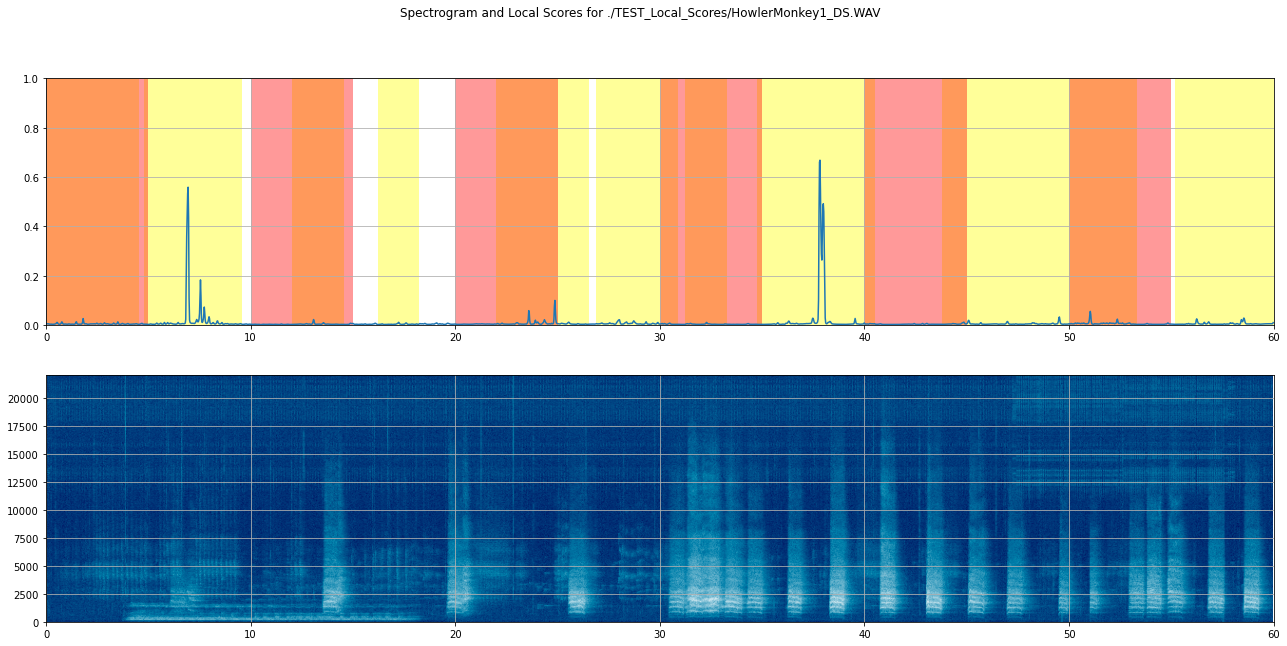

In [183]:
local_line_graph_reworked(local_score[0].tolist(),path,FS,SIGNAL,automated_df,human_df)

In [7]:
# Function that makes it easier for users to generate 
def local_score_visualization(clip_path,weight_path = None, human_df = None,automated_df = False, save_fig = False):
    
    # Loading in the clip with Microfaune's built-in loading function
    SAMPLE_RATE, SIGNAL = audio.load_wav(clip_path)
    
    # Initializing the detector to baseline or with retrained weights
    if weight_path == None:
        detector = RNNDetector()
    else:
        detector = RNNDetector(weight_path)
    
    # Computing Mel Spectrogram of the audio clip
    microfaune_features = detector.compute_features([SIGNAL])
    # Running the Mel Spectrogram through the RNN
    global_score,local_score = detector.predict(microfaune_features)
    
    # In the case where the user wants to look at automated bird labels
    if human_df is None:
        human_df = pd.DataFrame
    if automated_df == True:
        automated_df = isolate_reworked(local_score[0],SIGNAL, SAMPLE_RATE,"Doesn't","Matter")
    else:
        automated_df = pd.DataFrame()
        
    local_line_graph_reworked(local_score[0].tolist(),clip_path,SAMPLE_RATE,SIGNAL,automated_df,human_df, save = save_fig)

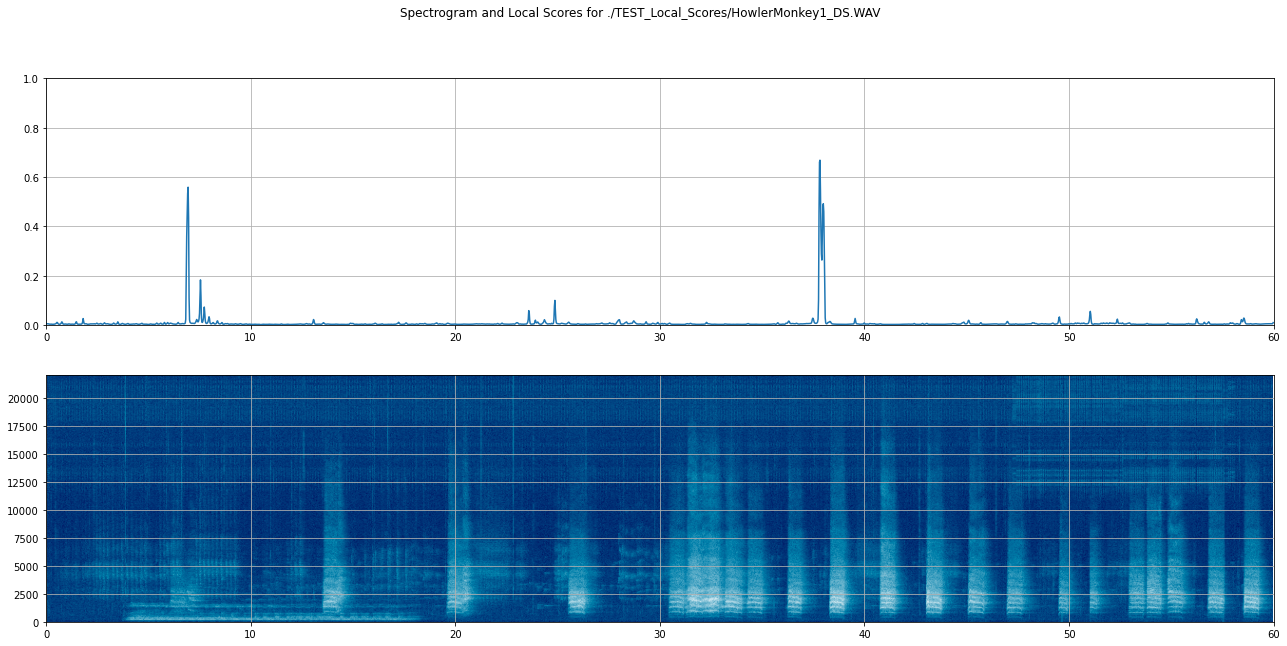

In [191]:
local_score_visualization(path)

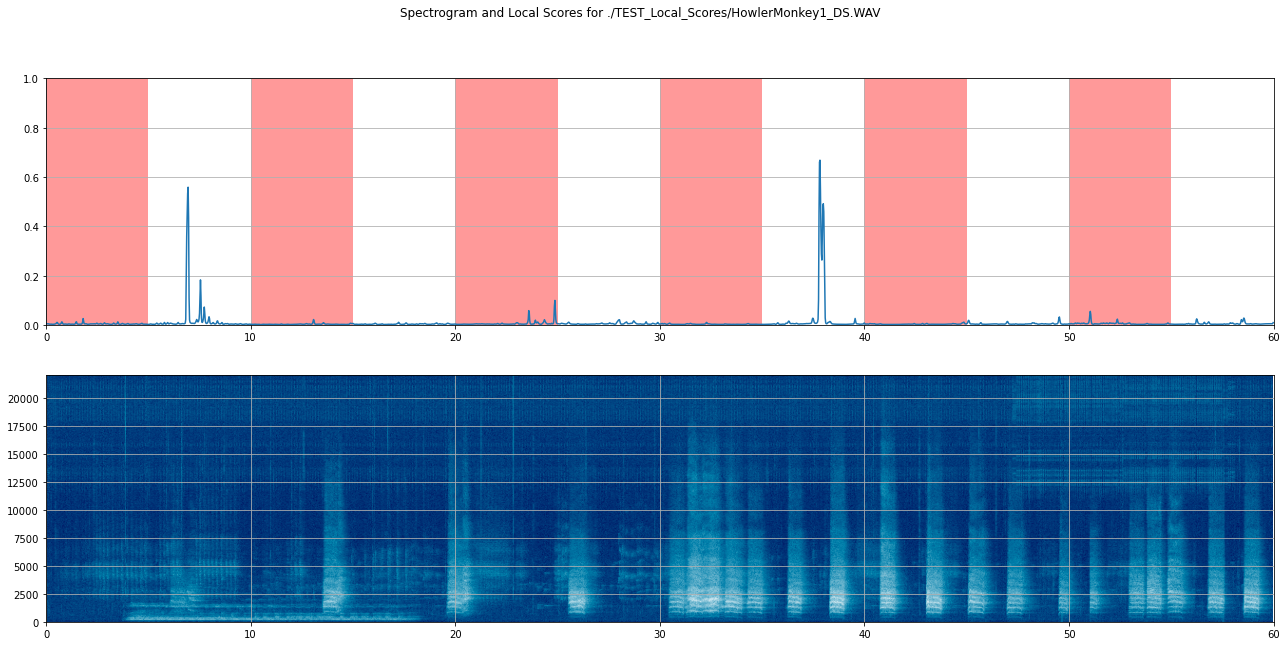

In [192]:
local_score_visualization(path,human_df = human_df)

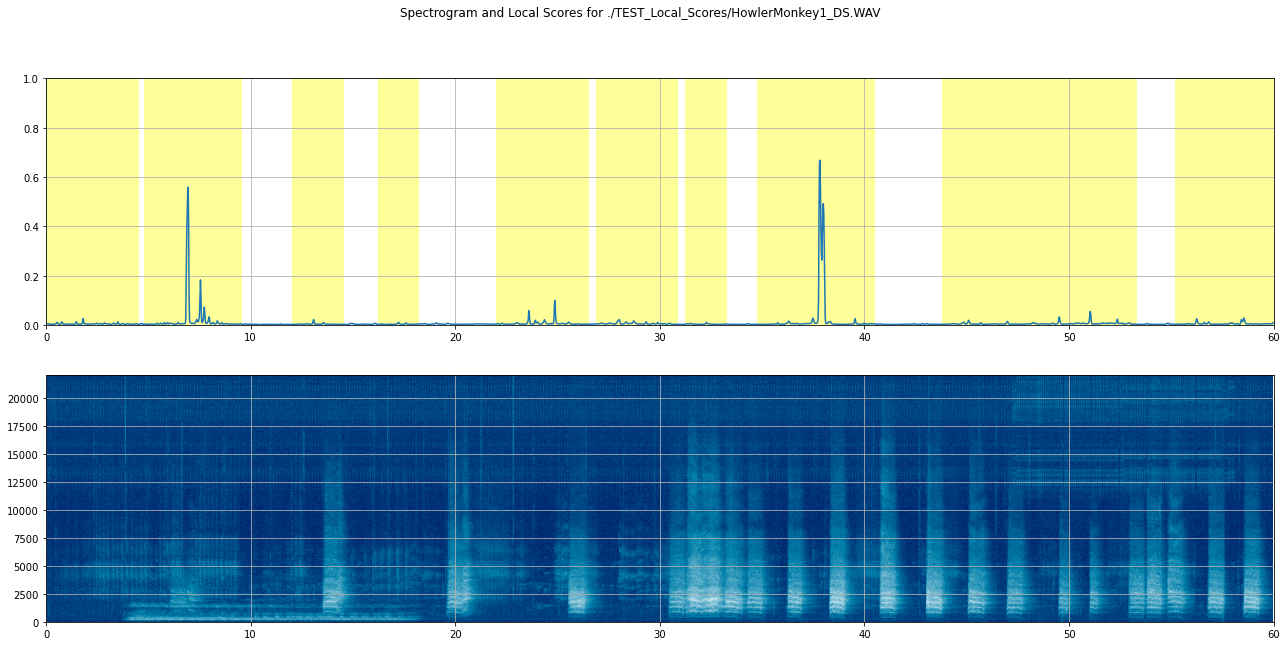

In [193]:
local_score_visualization(path,automated_df = True)

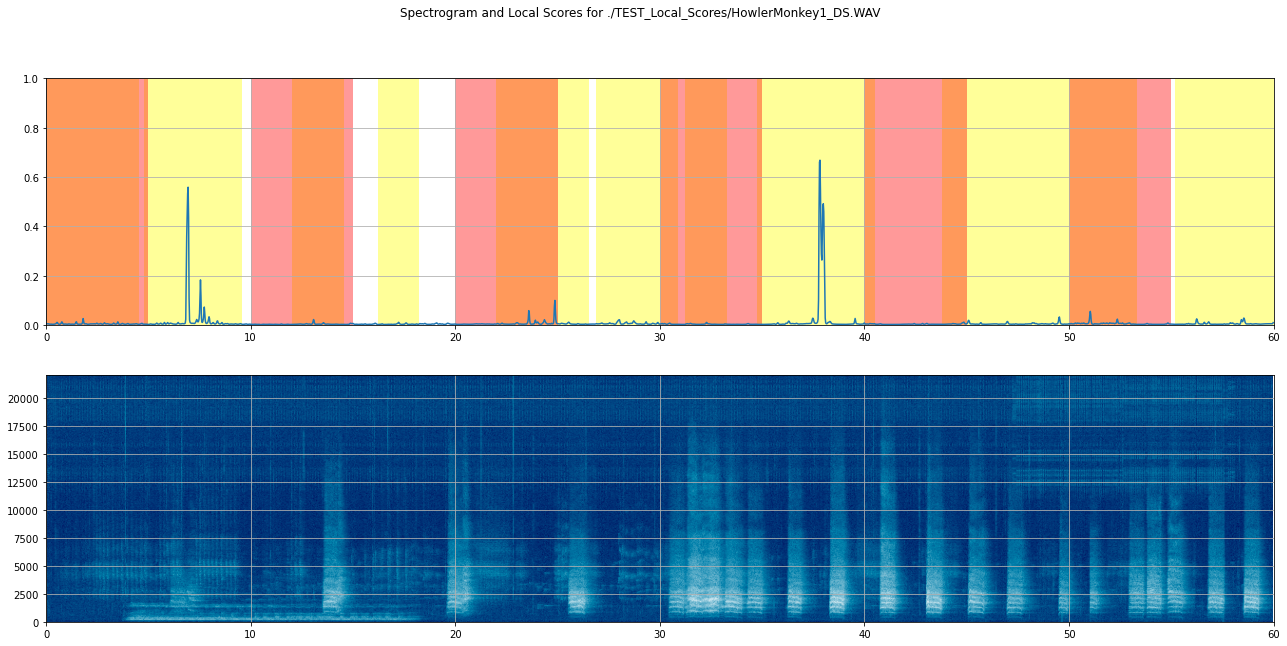

In [194]:
local_score_visualization(path,automated_df = True,human_df = human_df)

In [ ]:
## TODO Make it so that if a user wants to display automated labels, the global score is also outputted.
## TODO Encapsulate the overlap region into a function, and incorporate it into the visualization if a user 
## decides to display both the automated labels and the human labels.

In [40]:
def bird_label_scores(SIGNAL,SAMPLE_RATE,automated_df,human_df,plot_fig = False, save_fig = False):

    #duration = automated_df["DURATION"].to_list()[0]
    #SAMPLE_RATE = automated_df["SAMPLE RATE"].to_list()[0]
    # Initializing two arrays that will represent the human labels and automated labels with respect to 
    # the audio clip
    print(SIGNAL.shape)
    human_arr = np.zeros(SIGNAL.shape)
    bot_arr = np.zeros(SIGNAL.shape)
    
    folder_name = automated_df["FOLDER"].to_list()[0]
    clip_name = automated_df["IN FILE"].to_list()[0]
    # Placing 1s wherever the au
    for row in automated_df.index:
        minval = int(round(automated_df["OFFSET"][row]*SAMPLE_RATE,0))
        maxval = int(round((automated_df["OFFSET"][row] + automated_df["DURATION"][row]) *SAMPLE_RATE,0))
        bot_arr[minval:maxval] = 1
    for row in human_df.index:
        minval = int(round(human_df["OFFSET"][row]*SAMPLE_RATE,0))
        maxval = int(round((human_df["OFFSET"][row] + human_df["DURATION"][row])*SAMPLE_RATE,0))
        human_arr[minval:maxval] = 1
        
    human_arr_flipped = 1 - human_arr
    bot_arr_flipped = 1 - bot_arr
    
    true_positive_arr = human_arr*bot_arr
    false_negative_arr = human_arr * bot_arr_flipped
    false_positive_arr = human_arr_flipped * bot_arr
    true_negative_arr = human_arr_flipped * bot_arr_flipped
    
    true_positive_count = np.count_nonzero(true_positive_arr == 1)/SAMPLE_RATE
    false_negative_count = np.count_nonzero(false_negative_arr == 1)/SAMPLE_RATE
    false_positive_count = np.count_nonzero(false_positive_arr == 1)/SAMPLE_RATE
    true_negative_count = np.count_nonzero(true_negative_arr == 1)/SAMPLE_RATE
    
    # Calculating useful values related to tp,fn,fp,tn values
    
    # Precision = TP/(TP+FP)
    precision = true_positive_count/(true_positive_count + false_positive_count)
    
    # Recall = TP/(TP+FP)
    recall = true_positive_count/(true_positive_count + false_negative_count)
    
    # F1 = 2*(Recall*Precision)/(Recall + Precision)
    try:
        f1 = 2*(recall*precision)/(recall + precision)
    except:
        print("Error calculating f1 score, likely due to having true positive score of zero. Setting f1 to zero")
        f1 = 0

    # Creating a Dictionary which will be turned into a Pandas Dataframe
    entry = {'FOLDER'  : folder_name,
             'IN FILE'    : clip_name,
             'TRUE POSITIVE' : true_positive_count,
             'FALSE POSITIVE': false_positive_count,
             'FALSE NEGATIVE'  : false_negative_count,
             'TRUE POSITIVE'  : true_positive_count,
             'PRECISION' : precision,
             'RECALL' : recall,
             "F1" : f1}
    #print(entry)
    # Plotting the three arrays to visualize where 
    if plot_fig == True:
        plt.figure(figsize=(22,10))
        plt.subplot(6,1,1)
        plt.plot(human_arr)
        plt.title("Ground Truth for " + clip_name)
        plt.subplot(6,1,2)
        plt.plot(bot_arr)
        plt.title("Automated Label for " + clip_name)
        
        #Visualizing True Positives for the Automated Labeling
        plt.subplot(6,1,3)
        plt.plot(true_positive_arr)
        plt.title("True Positive for " + clip_name)
        
        #Visualizing False Negatives for the Automated Labeling
        plt.subplot(6,1,4)
        plt.plot(false_negative_arr)
        plt.title("False Negative for " + clip_name)
        
        plt.subplot(6,1,5)
        plt.plot(false_positive_arr)
        plt.title("False Positive for " + clip_name)
        
        plt.subplot(6,1,6)
        plt.plot(true_negative_arr)
        plt.title("True Negative for " + clip_name)
        
        plt.tight_layout()
        if save_fig == True:
            x = clip_name.split(".")
            clip_name = x[0]
            plt.save_fig(clip_name + "_label_plot.png")

    return pd.DataFrame(entry,index=[0])


In [65]:
# Helper function that will change a functions zeros and 1's. 

In [10]:
# Taking in a test clip
file_path = "./TEST/ScreamingPiha2.wav"
SAMPLE_RATE, SIGNAL = audio.load_wav(file_path)

if SAMPLE_RATE > 44100:
    rate_ratio = 44100 / SAMPLE_RATE
    SIGNAL = scipy_signal.resample(
                    SIGNAL, int(len(SIGNAL)*rate_ratio))
    SAMPLE_RATE = 44100
            # resample produces unreadable float32 array so convert back
            #SIGNAL = np.asarray(SIGNAL, dtype=np.int16)
            
        #print(SIGNAL.shape)
        # convert stereo to mono if needed
        # Might want to compare to just taking the first set of data.
if len(SIGNAL.shape) == 2:
    SIGNAL = SIGNAL.sum(axis=1) / 2

detector = RNNDetector()
microfaune_features = detector.compute_features([SIGNAL])
global_score,local_scores = detector.predict(microfaune_features)
automated_df = isolate_reworked(local_scores[0].tolist(),SIGNAL,SAMPLE_RATE,"ScreamingPiha2",file_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
test_df = bird_label_scores(SIGNAL,SAMPLE_RATE,automated_df,pd.read_csv("./ScreamingPiha2_Manual_Labels.csv"))
print(test_df)

           FOLDER                    IN FILE  TRUE POSITIVE  FALSE POSITIVE  \
0  ScreamingPiha2  ./TEST/ScreamingPiha2.wav      17.910204       10.580544   

   FALSE NEGATIVE  PRECISION    RECALL        F1  
0          2.4478   0.628632  0.879762  0.733292  


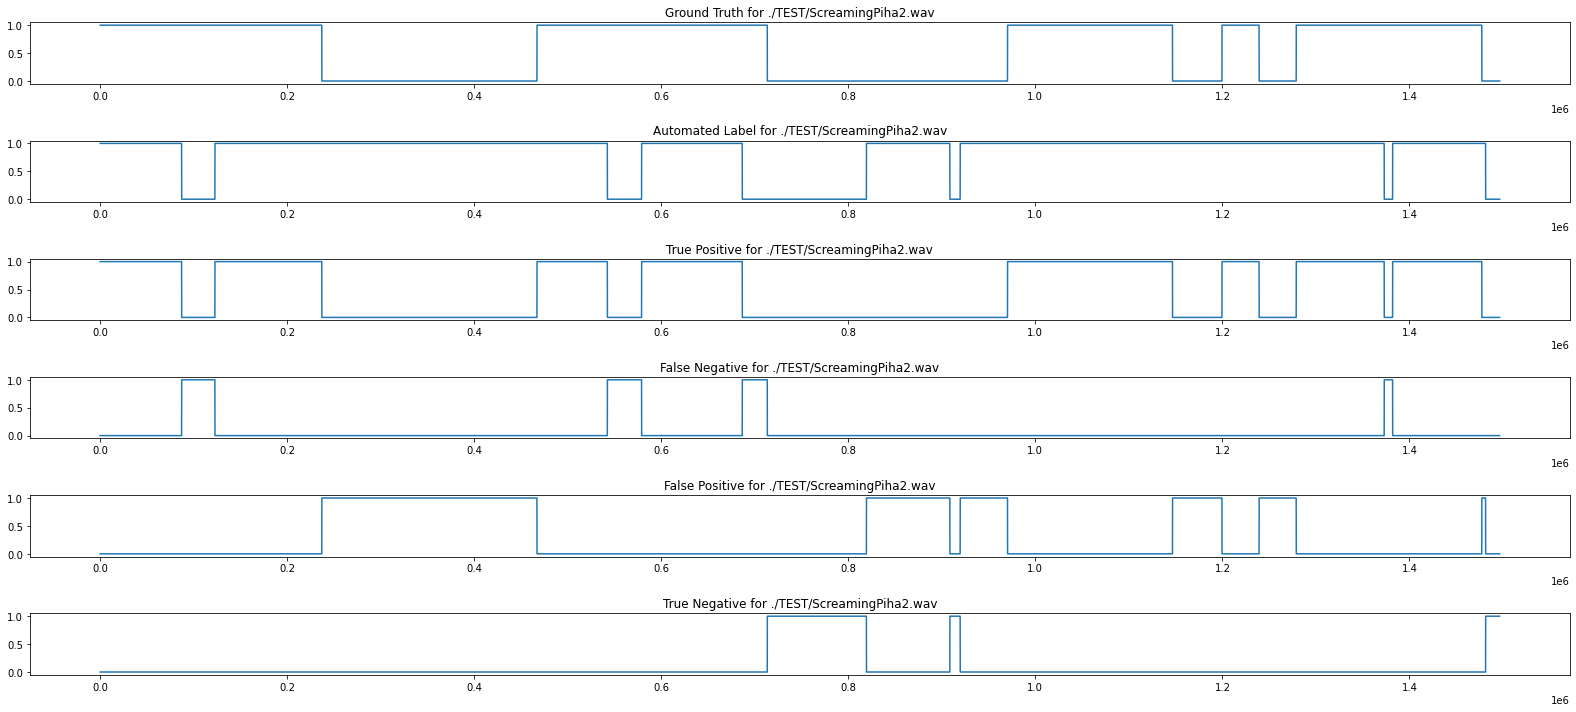

In [12]:
test = bird_label_scores(SIGNAL,SAMPLE_RATE,automated_df,pd.read_csv("./ScreamingPiha2_Manual_Labels.csv"),plot_fig=True)

In [34]:
automated_df = pd.read_csv("Automated_Labels_Updated.csv")
manual_df = pd.read_csv("Manual_Labels.csv")

In [35]:
#automated_df

In [36]:
#manual_df

In [37]:
clips = automated_df["IN FILE"].to_list()
clips = list( dict.fromkeys(clips) ) 
print(clips)

['20190622_210000.WAV', 'BlackFacedAntbird1.wav', '20190624_152000.WAV', 'ScreamingPiha2.wav', 'HowlerMonkey1.WAV', '20190623_222000.WAV']


In [38]:
#test_df = automated_df[automated_df["IN FILE"] == '20190624_152000.WAV']
#test_df
#print(test_df["IN FILE"].to_list()[0])

In [41]:
final_df = pd.DataFrame()
for clip in clips:
    clip_automated_df = automated_df[automated_df["IN FILE"] == clip]
    clip_manual_df = manual_df[manual_df["IN FILE"] == clip]
    folder = clip_automated_df["FOLDER"].to_list()[0]
    path = folder + clip
    print(path)
    SAMPLE_RATE, SIGNAL = audio.load_wav(path)
    try:
        score_df = bird_label_scores(SIGNAL,SAMPLE_RATE,clip_automated_df,clip_manual_df)
        if final_df.empty:
            final_df = score_df
        else:
            final_df = final_df.append(score_df)
    except:
        continue

./TEST/20190622_210000.WAV
(23040000,)
./TEST/BlackFacedAntbird1.wav
(1376640,)
./TEST/20190624_152000.WAV
(23040000,)
Error calculating f1 score, likely due to having true positive score of zero. Setting f1 to zero
./TEST/ScreamingPiha2.wav
(1496448, 2)
./TEST/HowlerMonkey1.WAV
(23040000,)
./TEST/20190623_222000.WAV
(23040000,)


In [14]:
final_df.to_csv("Overlap_Metrics_For_Audio_Dataset.csv",index=False)

In [55]:
def bird_label_scores(automated_df,human_df,plot_fig = False, save_fig = False):

    duration = automated_df["CLIP LENGTH"].to_list()[0]
    SAMPLE_RATE = automated_df["SAMPLE RATE"].to_list()[0]
    # Initializing two arrays that will represent the human labels and automated labels with respect to 
    # the audio clip
    #print(SIGNAL.shape)
    human_arr = np.zeros((int(SAMPLE_RATE*duration),))
    bot_arr = np.zeros((int(SAMPLE_RATE*duration),))
    
    folder_name = automated_df["FOLDER"].to_list()[0]
    clip_name = automated_df["IN FILE"].to_list()[0]
    # Placing 1s wherever the au
    for row in automated_df.index:
        minval = int(round(automated_df["OFFSET"][row]*SAMPLE_RATE,0))
        maxval = int(round((automated_df["OFFSET"][row] + automated_df["DURATION"][row]) *SAMPLE_RATE,0))
        bot_arr[minval:maxval] = 1
    for row in human_df.index:
        minval = int(round(human_df["OFFSET"][row]*SAMPLE_RATE,0))
        maxval = int(round((human_df["OFFSET"][row] + human_df["DURATION"][row])*SAMPLE_RATE,0))
        human_arr[minval:maxval] = 1
        
    human_arr_flipped = 1 - human_arr
    bot_arr_flipped = 1 - bot_arr
    
    true_positive_arr = human_arr*bot_arr
    false_negative_arr = human_arr * bot_arr_flipped
    false_positive_arr = human_arr_flipped * bot_arr
    true_negative_arr = human_arr_flipped * bot_arr_flipped
    
    true_positive_count = np.count_nonzero(true_positive_arr == 1)/SAMPLE_RATE
    false_negative_count = np.count_nonzero(false_negative_arr == 1)/SAMPLE_RATE
    false_positive_count = np.count_nonzero(false_positive_arr == 1)/SAMPLE_RATE
    true_negative_count = np.count_nonzero(true_negative_arr == 1)/SAMPLE_RATE
    
    # Calculating useful values related to tp,fn,fp,tn values
    
    # Precision = TP/(TP+FP)
    try:
        precision = true_positive_count/(true_positive_count + false_positive_count)
    
    
    # Recall = TP/(TP+FP)
        recall = true_positive_count/(true_positive_count + false_negative_count)
    
    # F1 = 2*(Recall*Precision)/(Recall + Precision)
    
        f1 = 2*(recall*precision)/(recall + precision)
    except:
        print("Error calculating statistics, likely due to zero division, setting values to zero")
        f1 = 0
        precision = 0
        recall = 0

    # Creating a Dictionary which will be turned into a Pandas Dataframe
    entry = {'FOLDER'  : folder_name,
             'IN FILE'    : clip_name,
             'TRUE POSITIVE' : true_positive_count,
             'FALSE POSITIVE': false_positive_count,
             'FALSE NEGATIVE'  : false_negative_count,
             'TRUE NEGATIVE'  : true_negative_count,
             'PRECISION' : precision,
             'RECALL' : recall,
             "F1" : f1}
    #print(entry)
    # Plotting the three arrays to visualize where 
    if plot_fig == True:
        plt.figure(figsize=(22,10))
        plt.subplot(6,1,1)
        plt.plot(human_arr)
        plt.title("Ground Truth for " + clip_name)
        plt.subplot(6,1,2)
        plt.plot(bot_arr)
        plt.title("Automated Label for " + clip_name)
        
        #Visualizing True Positives for the Automated Labeling
        plt.subplot(6,1,3)
        plt.plot(true_positive_arr)
        plt.title("True Positive for " + clip_name)
        
        #Visualizing False Negatives for the Automated Labeling
        plt.subplot(6,1,4)
        plt.plot(false_negative_arr)
        plt.title("False Negative for " + clip_name)
        
        plt.subplot(6,1,5)
        plt.plot(false_positive_arr)
        plt.title("False Positive for " + clip_name)
        
        plt.subplot(6,1,6)
        plt.plot(true_negative_arr)
        plt.title("True Negative for " + clip_name)
        
        plt.tight_layout()
        if save_fig == True:
            x = clip_name.split(".")
            clip_name = x[0]
            plt.save_fig(clip_name + "_label_plot.png")

    return pd.DataFrame(entry,index=[0])


In [56]:
# Function that will allow users to easily pass in two dataframes, and it will output statistics on them
# Will have to adjust the isolate function so that it adds a sampling rate onto the dataframes.
def automated_labeling_statistics(automated_df,manual_df):
    # Getting a list of clips
    clips = automated_df["IN FILE"].to_list()
    # Removing duplicates
    clips = list(dict.fromkeys(clips))
    # Initializing the returned dataframe
    statistics_df = pd.DataFrame()
    # Looping through each audio clip
    for clip in clips:
        clip_automated_df = automated_df[automated_df["IN FILE"] == clip]
        clip_manual_df = manual_df[manual_df["IN FILE"] == clip]
        #try:
        clip_stats_df = bird_label_scores(clip_automated_df,clip_manual_df)
        if statistics_df.empty:
            statistics_df = clip_stats_df
        else:
            statistics_df = statistics_df.append(clip_stats_df)
        #except:
        #    print("Something went wrong with: "+clip)
        #    continue
    return statistics_df

In [57]:
function_test_df = automated_labeling_statistics(automated_df,manual_df)

Error calculating statistics, likely due to zero division, setting values to zero


In [58]:
function_test_df

FOLDER                 IN FILE  TRUE POSITIVE  FALSE POSITIVE  \
0  ./TEST/     20190622_210000.WAV      47.977302        7.365828   
0  ./TEST/  BlackFacedAntbird1.wav       8.804218       14.305102   
0  ./TEST/     20190624_152000.WAV       0.000000        2.649524   
0  ./TEST/      ScreamingPiha2.wav      17.910204       10.580544   
0  ./TEST/       HowlerMonkey1.WAV      44.065510        0.600000   
0  ./TEST/     20190623_222000.WAV       8.472041        4.858299   

   FALSE NEGATIVE  TRUE NEGATIVE  PRECISION    RECALL        F1  
0        2.397710       2.259161   0.866906  0.952403  0.907646  
0        7.495782       0.611224   0.380981  0.540136  0.446809  
0        4.050000      53.300476   0.000000  0.000000  0.000000  
0        2.447800       2.994512   0.628632  0.879762  0.733292  
0       14.734490       0.600000   0.986567  0.749413  0.851791  
0        4.027959      42.641701   0.635546  0.677763  0.655976

In [59]:
# Small function that takes in the statistics and outputs their global values
def global_dataset_statistics(statistics_df):
    tp_sum = statistics_df["TRUE POSITIVE"].sum()
    fp_sum = statistics_df["FALSE POSITIVE"].sum()
    fn_sum = statistics_df["FALSE NEGATIVE"].sum()
    tn_sum = statistics_df["TRUE NEGATIVE"].sum()
    precision = tp_sum/(tp_sum + fp_sum)
    recall = tp_sum/(tp_sum + fn_sum)
    f1 = 2*(precision*recall)/(precision+recall)
    print("Dataset Precision: " + str(round(precision,4)))
    print("Dataset Recall: " + str(round(recall,4)))
    print("Dataset F1: " + str(round(f1,4)))

In [60]:
global_dataset_statistics(function_test_df)

Dataset Precision: 0.7592
Dataset Recall: 0.7835
Dataset F1: 0.7712
